# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of services to generate:  20


Number of service requests generated: 20


,Number of Services
OUIGO,3
AVLO,8
AVE,4
IRYO,4


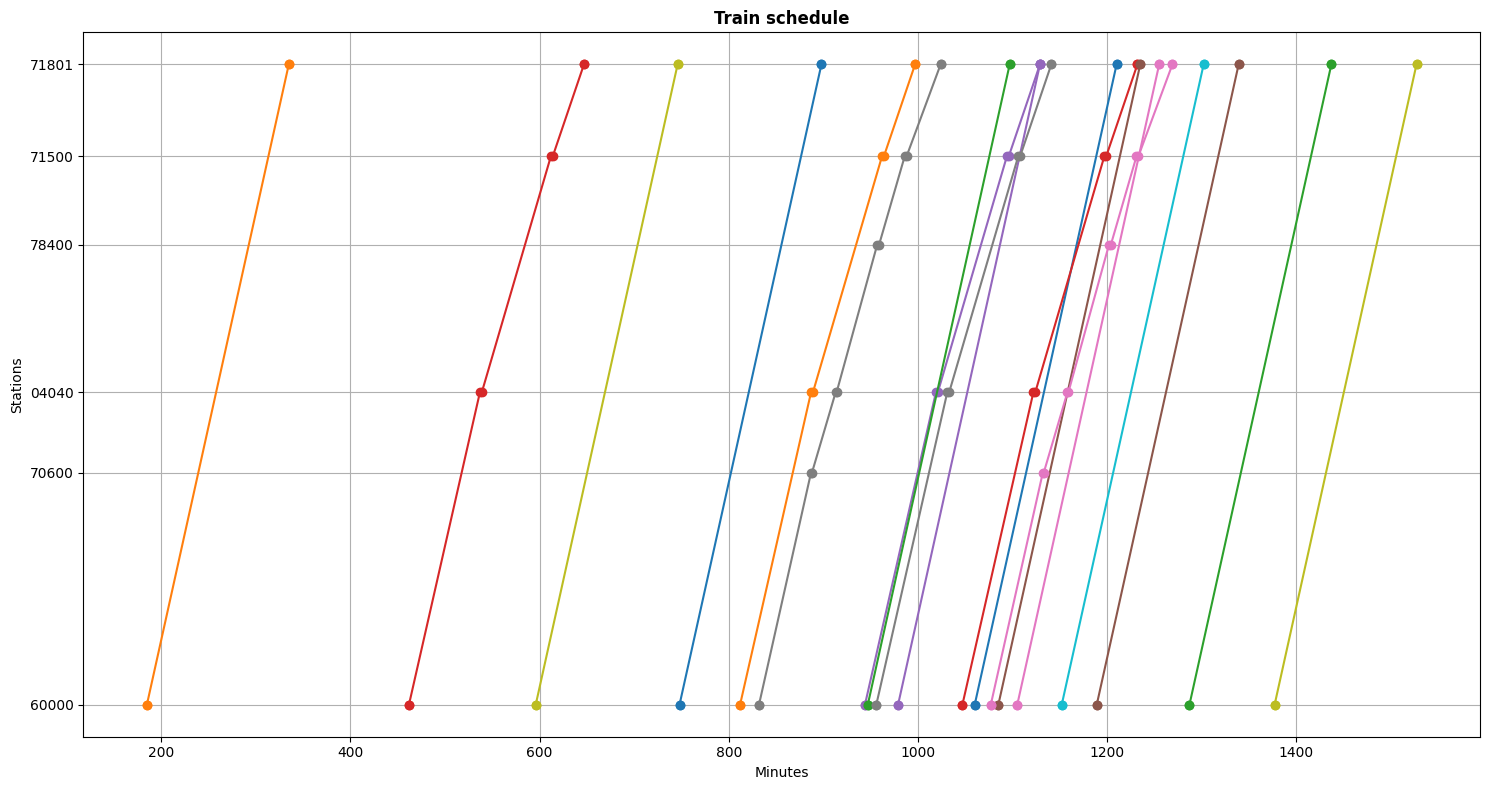

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


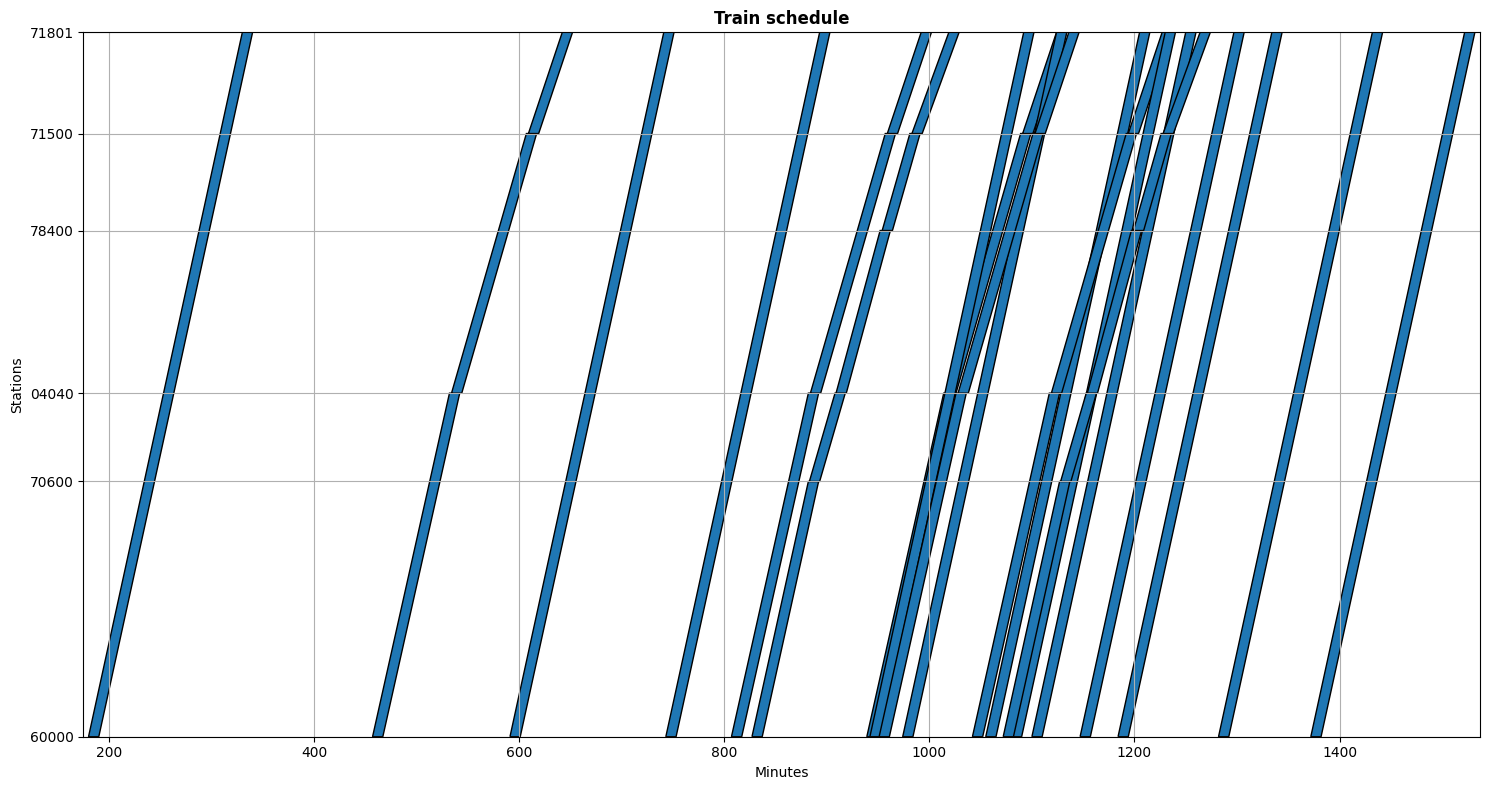

  0%|          | 0/1 [00:00<?, ?it/s]

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),AVLO,AVE,OUIGO,IRYO
0,1,2558.461735,3.437317,12,5.0,39.0,66.67 %,62.5 %,50.0 %,75.0 %


Global GSA status:
	Total execution time: 3.4373 s.
	Execution Time (by run) - Mean: 3.4373 s. - Std: nan s.
	Revenue - Mean: 2558.4617 - Std: nan
	Scheduled Trains - Mean: 12.0 - Std: nan
	Median solution: Run 1
	Max Revenue: 3888.5 - WARNING!: Scheduling all services could not be feasible


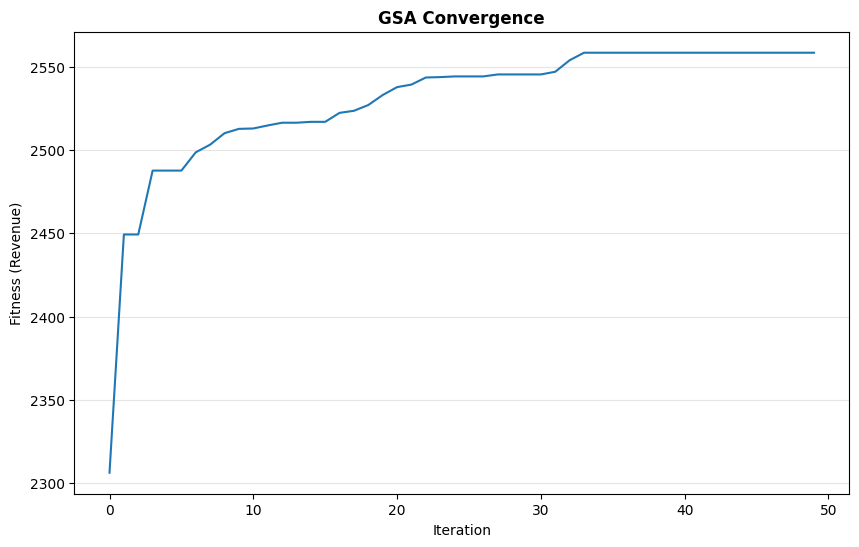

{'03612_2024-06-25-21.27': {'60000': [1287.0, 1287.0], '71801': [1437.0, 1437.0]}, '02731_2024-06-25-17.27': {'60000': [1047.0, 1047.0], '04040': [1122.0, 1125.0], '71500': [1198.0, 1204.0], '71801': [1237.0, 1237.0]}, '04161_2024-06-25-13.52': {'60000': [832.0, 832.0], '70600': [887.0, 888.0], '04040': [913.0, 917.0], '78400': [960.0, 962.0], '71500': [989.0, 996.0], '71801': [1032.0, 1032.0]}, '03612_2024-06-25-22.57': {'60000': [1374.0, 1374.0], '71801': [1524.0, 1524.0]}, '03612_2024-06-25-19.12': {'60000': [1152.0, 1152.0], '71801': [1302.0, 1302.0]}, '03612_2024-06-25-12.28': {'60000': [748.0, 748.0], '71801': [898.0, 898.0]}, '03612_2024-06-25-3.05': {'60000': [185.0, 185.0], '71801': [335.0, 335.0]}, '02731_2024-06-25-7.42': {'60000': [461.0, 461.0], '04040': [536.0, 539.0], '71500': [612.0, 616.0], '71801': [649.0, 649.0]}, '03612_2024-06-25-19.49': {'60000': [1190.0, 1190.0], '71801': [1340.0, 1340.0]}, '04161_2024-06-25-17.57': {'60000': [1077.0, 1077.0], '70600': [1132.0, 1

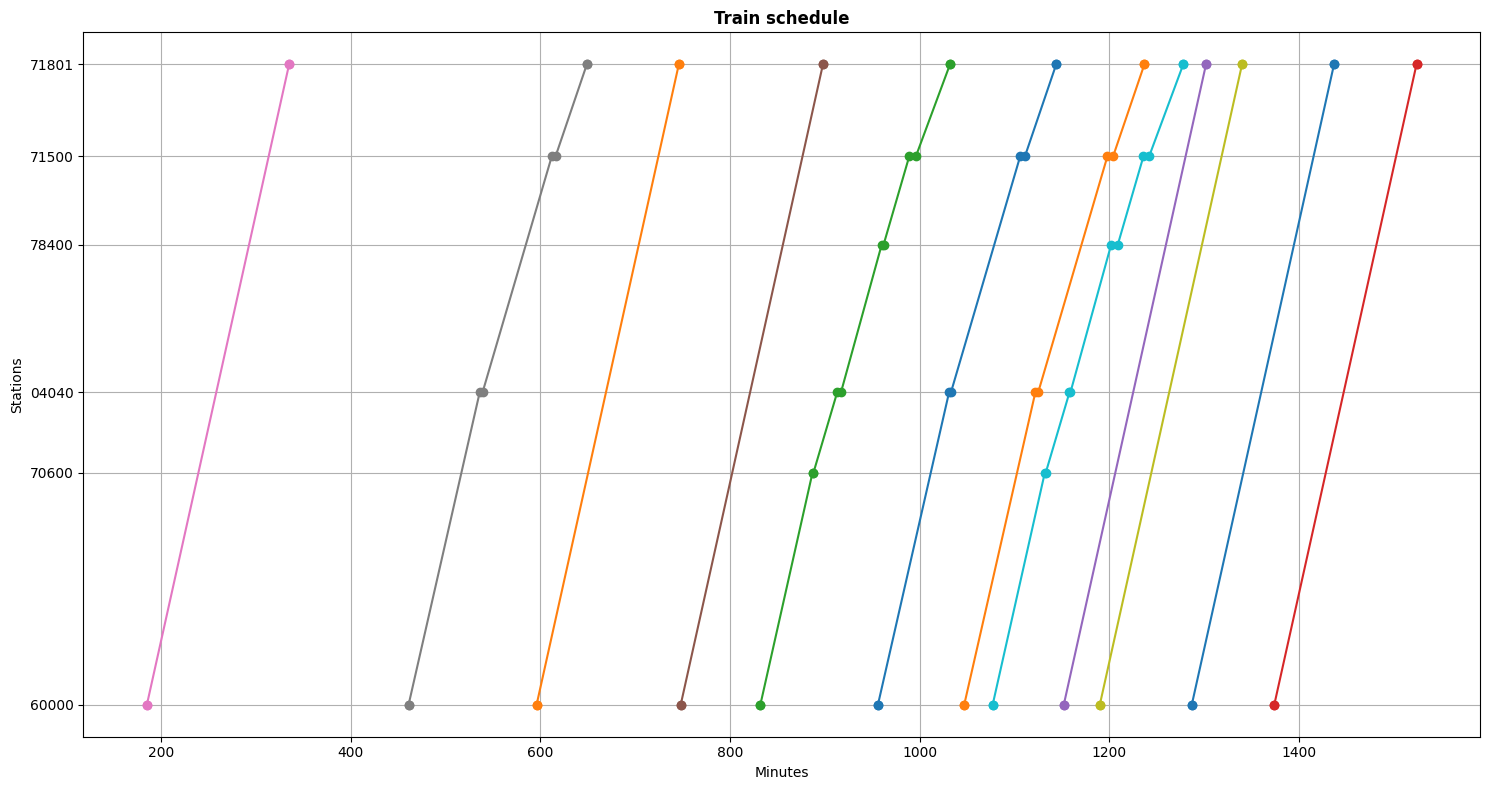

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


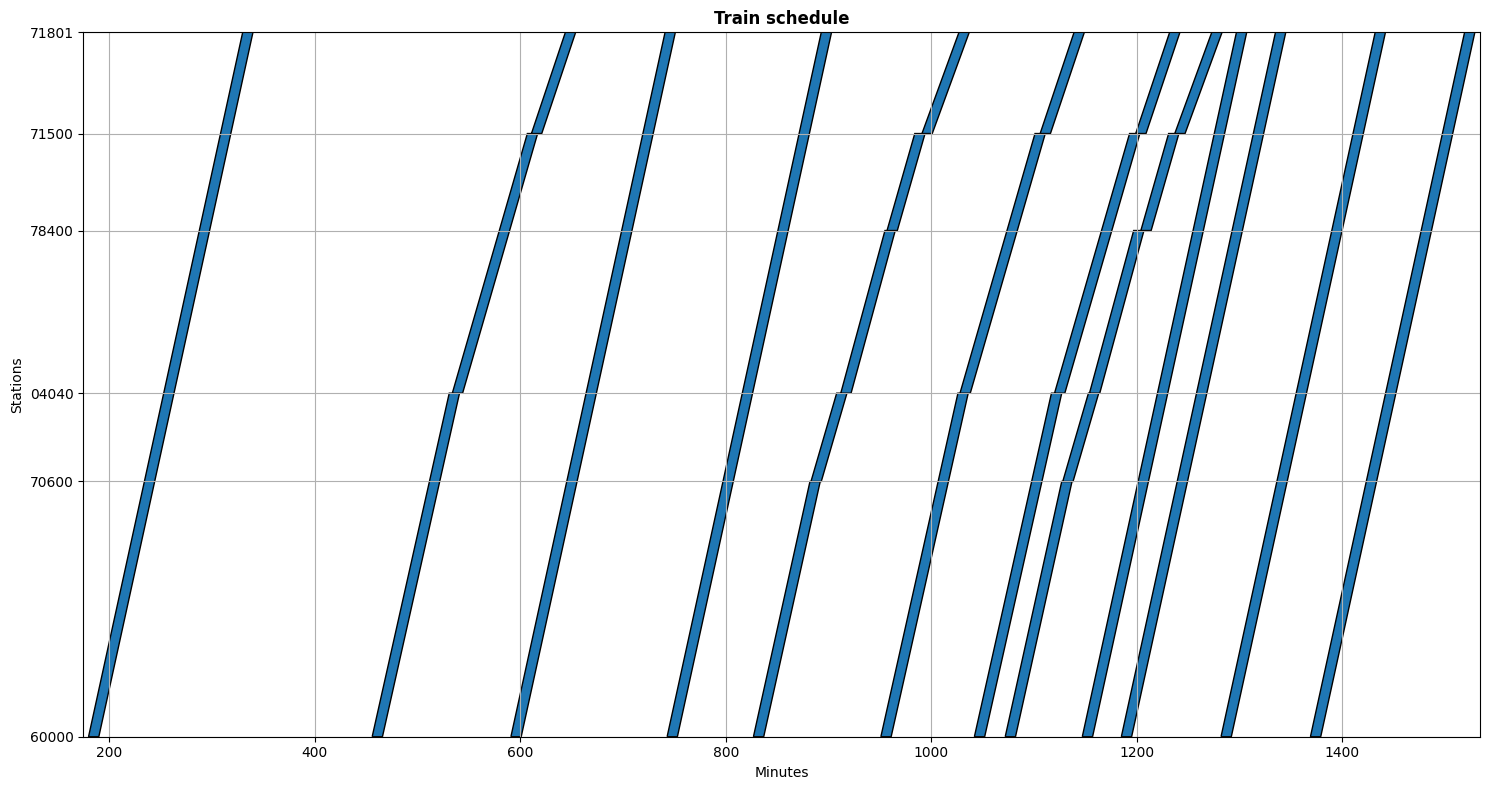

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 5405
	Status: User bought a service which was not the one with the best utility. - Passengers: 2806
	Status: User bought the ticket with best utility. - Passengers: 955
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  3761
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 667 - Percentage: 17.73 %
		Seat: Turista - Passengers: 2442 - Percentage: 64.93 %
		Seat: TuristaPlus - Passengers: 652 - Percentage: 17.34 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  3761
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 18
			Seat: Turista - Number of tickets sold: 73
			Seat: TuristaPlus - Number of tickets sold: 67
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 12
			Seat: Turista - Number of tic

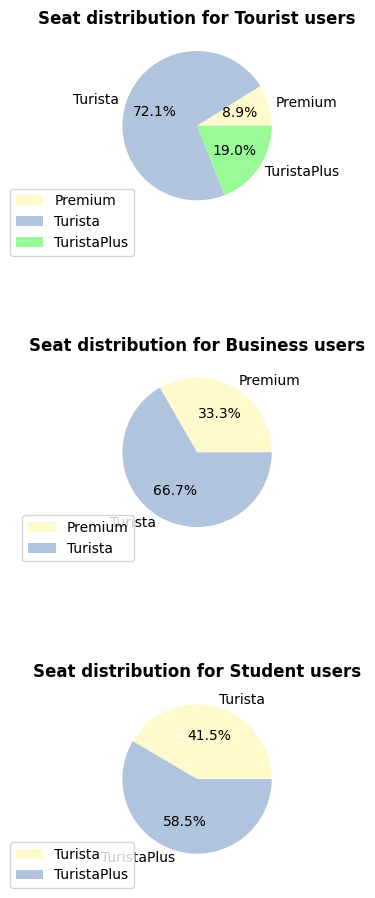

In [3]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path=generator_save_path,
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=Path(f'{robin_save_path}output.csv'),
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=1,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!
